In [1]:
import os
import sys
import time
import copy

import numpy as np
import math
import random
import matplotlib.pyplot as plt

import functools
import argparse

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils

import pickle

import datasets, models
import importlib
importlib.reload(models)
import init, measures

In [2]:
from dataclasses import dataclass
@dataclass
class config:

    device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'

    dataset = 'rhm'
    mode = 'masked'
    num_features = 16
    num_classes = 16
    num_synonyms = 4
    tuple_size = 2
    num_layers = 3
    seed_rules = 2362346
    num_tokens = 8 # context length, tuple_size**num_layers for the full input

    train_size = 131072
    batch_size = 256
    accumulation = 1
    test_size = 32768
    seed_sample = 34534
    replacement = False

    input_format = 'onehot'
    whitening = 1

    model = 'hcnn'
    depth = 3
    width = 256
    filter_size = 2
    # model = 'transformer_mla'
    # depth = 3
    # num_heads = 16
    # embedding_dim = 256
    bias = False
    seed_model = 359

    optim = 'sgd'
    lr = 1.0
    momentum = 0.0
    scheduler = None
    scheduler_time = 1024
    max_epochs = 1024

    print_freq = 64
    save_freq = 3
    loss_threshold = 1e-3

    outname = 'test'

config.rules = True
config.bonus = dict.fromkeys(['noise', 'synonyms', 'size'])
config.bonus['size'] = config.test_size
config.check_rules = False

config.zipf = None
config.layer = config.num_layers

config.num_data = config.num_classes*config.num_synonyms**((config.tuple_size**config.num_layers-1)//(config.tuple_size-1))
config.input_size = config.tuple_size**config.num_layers
config.num_batches = config.train_size//config.batch_size
config.max_iters = config.max_epochs*config.num_batches

scales = []
for i in range(config.num_layers):
    scales.append(config.num_classes*config.num_synonyms**(2*i+1)/(1.-config.num_synonyms/(config.num_features**config.tuple_size)))
print(config.num_data, config.num_classes*config.num_synonyms**(config.num_layers), scales)

print(config.device)

262144 1024 [65.01587301587301, 1040.2539682539682, 16644.06349206349]
mps


In [3]:
train_loader, test_loader = init.init_data(config)

if config.bonus:

    if 'rules' in config.bonus:
        print(config.bonus['rules'][0].size())

    if 'synonyms' in config.bonus:
        for k in config.bonus['synonyms']:
            print(k, config.bonus['features'][0].argmax(dim=0)+1)
            print(k, config.bonus['synonyms'][k][0].argmax(dim=0)+1)
    if 'noise' in config.bonus:
        for k in config.bonus['noise']:
            print(k, config.bonus['features'][0].argmax(dim=0)+1)
            print(k, config.bonus['noise'][k][0].argmax(dim=0)+1)

3 tensor([14,  6, 11,  4, 13, 13, 11,  1])
3 tensor([ 1,  7,  4, 16, 13, 16, 12,  1], device='mps:0')
2 tensor([14,  6, 11,  4, 13, 13, 11,  1])
2 tensor([11,  7, 10,  5, 13, 13, 11,  1], device='mps:0')
1 tensor([14,  6, 11,  4, 13, 13, 11,  1])
1 tensor([14,  6, 11,  4,  1,  3, 11,  1], device='mps:0')
3 tensor([14,  6, 11,  4, 13, 13, 11,  1])
3 tensor([16, 10, 12,  3, 15,  9,  1,  1], device='mps:0')
2 tensor([14,  6, 11,  4, 13, 13, 11,  1])
2 tensor([ 1,  7, 16,  3, 13, 13, 11,  1], device='mps:0')
1 tensor([14,  6, 11,  4, 13, 13, 11,  1])
1 tensor([14,  6, 11,  4,  9, 10, 11,  1], device='mps:0')
0 tensor([14,  6, 11,  4, 13, 13, 11,  1])
0 tensor([14,  6, 11,  4, 13, 13,  8,  1], device='mps:0')


In [4]:
for x, y in train_loader:
    print(x.size(), y.size(), x.device)

torch.Size([256, 16, 8]) torch.Size([256]) cpu
torch.Size([256, 16, 8]) torch.Size([256]) cpu
torch.Size([256, 16, 8]) torch.Size([256]) cpu
torch.Size([256, 16, 8]) torch.Size([256]) cpu
torch.Size([256, 16, 8]) torch.Size([256]) cpu
torch.Size([256, 16, 8]) torch.Size([256]) cpu
torch.Size([256, 16, 8]) torch.Size([256]) cpu
torch.Size([256, 16, 8]) torch.Size([256]) cpu
torch.Size([256, 16, 8]) torch.Size([256]) cpu
torch.Size([256, 16, 8]) torch.Size([256]) cpu
torch.Size([256, 16, 8]) torch.Size([256]) cpu
torch.Size([256, 16, 8]) torch.Size([256]) cpu
torch.Size([256, 16, 8]) torch.Size([256]) cpu
torch.Size([256, 16, 8]) torch.Size([256]) cpu
torch.Size([256, 16, 8]) torch.Size([256]) cpu
torch.Size([256, 16, 8]) torch.Size([256]) cpu
torch.Size([256, 16, 8]) torch.Size([256]) cpu
torch.Size([256, 16, 8]) torch.Size([256]) cpu
torch.Size([256, 16, 8]) torch.Size([256]) cpu
torch.Size([256, 16, 8]) torch.Size([256]) cpu
torch.Size([256, 16, 8]) torch.Size([256]) cpu
torch.Size([2

In [5]:
model = init.init_model(config)
model0 = copy.deepcopy( model)
param_count = sum([p.numel() for p in model.parameters()])
print(param_count)

274432


In [6]:
criterion, optimizer, scheduler = init.init_training( model, config)

In [7]:
%%time
dynamics, best = init.init_output(model, criterion, train_loader, test_loader, config)
print(dynamics[0])

if config.bonus:
    if 'synonyms' in config.bonus:
        for l in range(config.depth+1):
            for k in dynamics[0]['synonyms'][l].keys():
                print(f'depth {l}, level {k}, sensitivity: ', dynamics[0]['synonyms'][l][k].mean().item())
    if 'noise' in config.bonus:
        for l in range(config.depth+1):
            for k in dynamics[0]['noise'][l].keys():
                print(f'depth {l}, level {k}, sensitivity: ', dynamics[0]['noise'][l][k].mean().item())

{'t': 0, 'trainloss': 2.772907054051757, 'trainacc': 0.06198883056640625, 'testloss': 2.7728738337755203, 'testacc': 0.063812255859375, 'synonyms': {0: {3: tensor([0.3108, 0.3089, 0.3118, 0.2785], device='mps:0'), 2: tensor([0.2657, 0.2837, 1.0000, 1.0000], device='mps:0'), 1: tensor([1.0000, 1.0000, 0.2362, 1.0000], device='mps:0')}, 1: {3: tensor([0.3110, 0.2967], device='mps:0'), 2: tensor([0.2711, 1.0000], device='mps:0'), 1: tensor([1.0000, 0.4465], device='mps:0')}, 2: {3: tensor([0.2961], device='mps:0'), 2: tensor([0.5192], device='mps:0'), 1: tensor([0.7038], device='mps:0')}, 3: {3: tensor(0.3050, device='mps:0'), 2: tensor(0.5298, device='mps:0'), 1: tensor(0.7538, device='mps:0')}}, 'noise': {0: {3: tensor([0.1321, 0.1408, 0.1397, 0.1241], device='mps:0'), 2: tensor([0.0850, 0.0831, 1.0000, 1.0000], device='mps:0'), 1: tensor([1.0000, 1.0000, 0.0396, 1.0000], device='mps:0'), 0: tensor([ 1.0000e+00,  1.0000e+00,  1.0000e+00, -2.7157e-04], device='mps:0')}, 1: {3: tensor([0.

In [ ]:
# for key in dynamics[0]['synonyms'].keys():
#     print(dynamics[0]['synonyms'][key])

{3: tensor([0.3108, 0.3089, 0.3118, 0.2785], device='mps:0'), 2: tensor([0.2657, 0.2837, 1.0000, 1.0000], device='mps:0'), 1: tensor([1.0000, 1.0000, 0.2362, 1.0000], device='mps:0')}
{3: tensor([0.3110, 0.2967], device='mps:0'), 2: tensor([0.2711, 1.0000], device='mps:0'), 1: tensor([1.0000, 0.4465], device='mps:0')}
{3: tensor([0.2961], device='mps:0'), 2: tensor([0.5192], device='mps:0'), 1: tensor([0.7038], device='mps:0')}
{3: tensor(0.3050, device='mps:0'), 2: tensor(0.5298, device='mps:0'), 1: tensor(0.7538, device='mps:0')}


In [11]:
# config.print_freq = 256
# config.save_freq = 3

print_ckpts, save_ckpts = init.init_loglinckpt( config.print_freq, config.max_iters, freq=config.save_freq)
print_ckpt = next(print_ckpts)
save_ckpt = next(save_ckpts)

step = 0

## TRAINING

In [13]:
for epoch in range(config.max_epochs):

    model.train()
    optimizer.zero_grad()
    running_loss = 0.

    for batch_idx, (inputs, targets) in enumerate(train_loader):

        outputs = model(inputs.to(config.device))
        loss = criterion(outputs, targets.to(config.device))
        running_loss += loss.item()
        loss /= config.accumulation
        loss.backward()

        if ((batch_idx+1)%config.accumulation==0):
            optimizer.step()
            optimizer.zero_grad()
            scheduler.step()
            step += 1

            if step==print_ckpt:

                test_loss, test_acc = measures.test(model, test_loader, config.device)

                if test_loss<best['loss']: # update best model if loss is smaller
                    best['step'] = step
                    best['loss'] = test_loss
                    best['model'] = copy.deepcopy( model.state_dict())

                print('step : ',step, '\t train loss: {:06.4f}'.format(running_loss/(batch_idx+1)), ',test loss: {:06.4f}'.format(test_loss))
                print_ckpt = next(print_ckpts)

                if step>=save_ckpt:

                    print(f'Checkpoint at step {step}, saving data ...')

                    train_loss, train_acc = measures.test(model, train_loader, config.device)
                    save_dict = {'t': step, 'trainloss': train_loss, 'trainacc': train_acc, 'testloss': test_loss, 'testacc': test_acc}
                    if config.bonus:
                        if 'synonyms' in config.bonus:
                            save_dict['synonyms'] = measures.sensitivity( model, config.bonus['features'], config.bonus['synonyms'], config.device)
                        if 'noise' in config.bonus:
                            save_dict['noise'] = measures.sensitivity( model, config.bonus['features'], config.bonus['noise'], config.device)
                    dynamics.append(save_dict)
                    save_ckpt = next(save_ckpts)


    if (running_loss/(batch_idx+1)) <= config.loss_threshold:

        train_loss, train_acc = measures.test(model, train_loader, config.device)
        save_dict = {'t': step, 'trainloss': train_loss, 'trainacc': train_acc, 'testloss': test_loss, 'testacc': test_acc}
        if config.bonus:
            if 'synonyms' in config.bonus:
                save_dict['synonyms'] = measures.sensitivity( model, config.bonus['features'], config.bonus['synonyms'], config.device)
            if 'noise' in config.bonus:
                save_dict['noise'] = measures.sensitivity( model, config.bonus['features'], config.bonus['noise'], config.device)
        dynamics.append(save_dict)

        break

step :  2 	 train loss: 2.7723 ,test loss: 2.7726
Checkpoint at step 2, saving data ...
step :  3 	 train loss: 2.7724 ,test loss: 2.7725
Checkpoint at step 3, saving data ...
step :  4 	 train loss: 2.7724 ,test loss: 2.7724
Checkpoint at step 4, saving data ...
step :  5 	 train loss: 2.7722 ,test loss: 2.7723
Checkpoint at step 5, saving data ...
step :  6 	 train loss: 2.7722 ,test loss: 2.7721
Checkpoint at step 6, saving data ...
step :  7 	 train loss: 2.7722 ,test loss: 2.7720
Checkpoint at step 7, saving data ...
step :  8 	 train loss: 2.7722 ,test loss: 2.7719
Checkpoint at step 8, saving data ...
step :  10 	 train loss: 2.7721 ,test loss: 2.7717
Checkpoint at step 10, saving data ...
step :  13 	 train loss: 2.7719 ,test loss: 2.7713
Checkpoint at step 13, saving data ...
step :  16 	 train loss: 2.7717 ,test loss: 2.7709
Checkpoint at step 16, saving data ...
step :  20 	 train loss: 2.7716 ,test loss: 2.7705
Checkpoint at step 20, saving data ...
step :  25 	 train loss:

KeyboardInterrupt: 

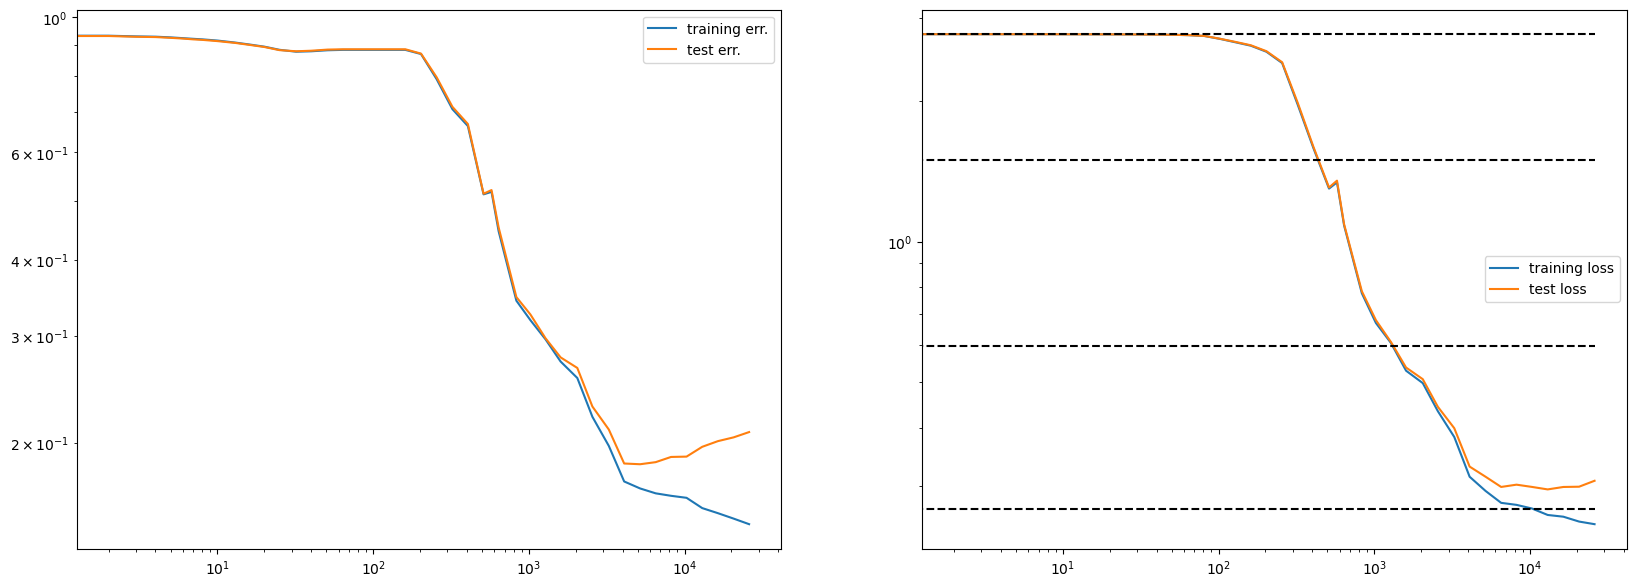

In [14]:
import math

fig, ax = plt.subplots(1, 2, figsize=(20,7))

ax[0].plot([d['t'] for d in dynamics], [1.-d['trainacc'] for d in dynamics], f'C0', label='training err.')
ax[0].plot([d['t'] for d in dynamics], [1.-d['testacc'] for d in dynamics], f'C1', label='test err.')

ax[1].plot([d['t'] for d in dynamics], [d['trainloss'] for d in dynamics], f'C0', label='training loss')
ax[1].plot([d['t'] for d in dynamics], [d['testloss'] for d in dynamics], f'C1', label='test loss')

L = config.num_layers
v = config.num_features
m = config.num_synonyms
s = config.tuple_size
time = [d['t'] for d in dynamics]

ngram_losses = [math.log(config.num_features), 1.4926, 0.5973, 0.2686] #v=16, m=4
# ngram_losses = [math.log(config.num_features), 2.1266, 1.0060, 0.4300, 0.2491, 0.2025, 0.1911, 0.1883, 0.1876] # v = 32, m = 8

for k in range(L+1):
    # compatible = (v-1)*((v**s-m*v)/(v**s-1-m*(v-1)))*((m*(v-1))/(v**s-1))**k + (v-1)*(m-1)/(v**s-1-m*(v-1))
    # ax[1].plot([t for t in time], [math.log(1+compatible) for t in time], 'k--')
    ax[1].plot([t for t in time], [ngram_losses[k] for t in time], 'k--')


ax[0].legend()
ax[0].set_xscale('log')
ax[0].set_yscale('log')

ax[1].legend()
ax[1].set_xscale('log')
ax[1].set_yscale('log')
# ax[1].set_ylim(1e-1,1e1)

In [15]:
if config.bonus:
    if 'synonyms' in config.bonus:
        for k in range(config.depth+1):
            for l in range(1,config.num_layers):
                print(f'depth {k}, level {l}, sensitivity: ', dynamics[0]['synonyms'][k][l].mean().item())

depth 0, level 1, sensitivity:  0.8090558052062988
depth 0, level 2, sensitivity:  0.6373489499092102
depth 1, level 1, sensitivity:  0.7232600450515747
depth 1, level 2, sensitivity:  0.6355370879173279
depth 2, level 1, sensitivity:  0.703819990158081
depth 2, level 2, sensitivity:  0.5192206501960754
depth 3, level 1, sensitivity:  0.7537670731544495
depth 3, level 2, sensitivity:  0.5297514200210571


In [31]:
print(dynamics[0]['noise'].keys())

for key in dynamics[0]['noise'].keys():
    print(f'rep. {key+1}', dynamics[-1]['noise'][key])

dict_keys([0, 1, 2, 3])
rep. 1 {3: tensor([0.1219, 0.1295, 0.1250, 0.1285], device='mps:0'), 2: tensor([0.0734, 0.0740, 1.0000, 1.0000], device='mps:0'), 1: tensor([1.0000, 1.0000, 0.0297, 1.0000], device='mps:0'), 0: tensor([1.0000e+00, 1.0000e+00, 1.0000e+00, 1.8618e-05], device='mps:0')}
rep. 2 {3: tensor([0.1052, 0.1152], device='mps:0'), 2: tensor([0.0515, 1.0000], device='mps:0'), 1: tensor([1.0000, 0.3773], device='mps:0'), 0: tensor([1.0000, 0.3778], device='mps:0')}
rep. 3 {3: tensor([0.1013], device='mps:0'), 2: tensor([0.6190], device='mps:0'), 1: tensor([0.5349], device='mps:0'), 0: tensor([0.4361], device='mps:0')}
rep. 4 {3: tensor(0.1177, device='mps:0'), 2: tensor(0.8778, device='mps:0'), 1: tensor(0.5711, device='mps:0'), 0: tensor(0.2328, device='mps:0')}


dict_keys([0, 1, 2, 3])
dict_keys([3, 2, 1])


IndexError: index -1 is out of bounds for dimension 0 with size 0

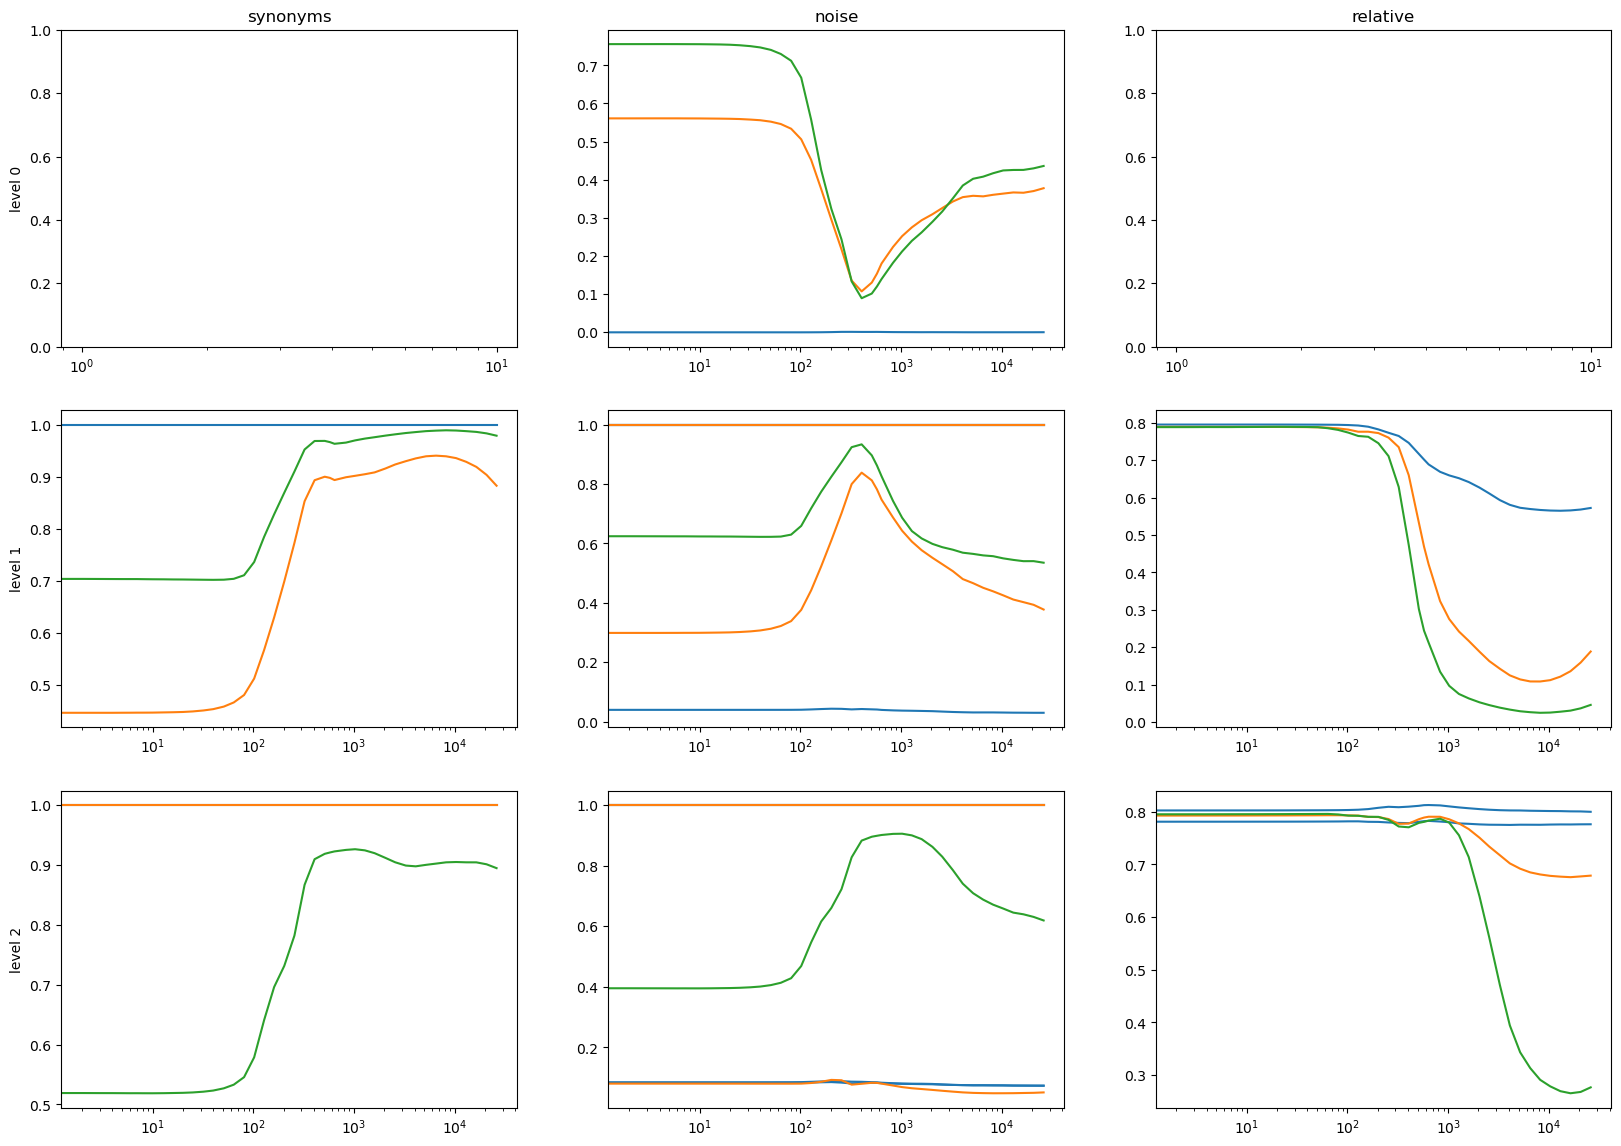

In [ ]:
fig, ax = plt.subplots((config.num_layers), 3, figsize=(20,14))


print(dynamics[-1]['synonyms'].keys())
print(dynamics[-1]['synonyms'][3].keys())

ax[0][0].set_title('synonyms')
ax[0][1].set_title('noise')
ax[0][2].set_title('relative')

for k in range(config.depth+1):

    l = 0
    ax[0][1].plot([d['t'] for d in dynamics], [d['noise'][k][l].to('cpu') for d in dynamics], f'C{k}' , label=f'{k+1}-th rep.')

    ax[l][0].set_ylabel(f'level {l}')
    ax[0][0].set_xscale('log')
    ax[0][1].set_xscale('log')
    ax[0][2].set_xscale('log')


    for l in range(1,config.num_layers):

        ax[l][0].plot([d['t'] for d in dynamics], [d['synonyms'][k][l].to('cpu') for d in dynamics], f'C{k}' , label=f'{k+1}-th rep.')
        ax[l][1].plot([d['t'] for d in dynamics], [d['noise'][k][l].to('cpu') for d in dynamics], f'C{k}' , label=f'{k+1}-th rep.')
        ax[l][2].plot([d['t'] for d in dynamics], [(1.-d['synonyms'][k][l].to('cpu'))/((1.-d['noise'][k][l].to('cpu'))) for d in dynamics], f'C{k}' , label=f'{k+1}-th rep.')

        ax[l][0].set_ylabel(f'level {l}')
        ax[l][0].set_xscale('log')
        ax[l][1].set_xscale('log')
        ax[l][2].set_xscale('log')

init_loss = dynamics[0]['testloss']
for l in range(config.num_layers):

    ax[l][0].plot([d['t'] for d in dynamics], [d['testloss']/init_loss for d in dynamics], f'k--')
    ax[l][1].plot([d['t'] for d in dynamics], [d['testloss']/init_loss for d in dynamics], f'k--')
    ax[l][2].plot([d['t'] for d in dynamics], [d['testloss']/init_loss for d in dynamics], f'k--')

ax[0][1].legend()

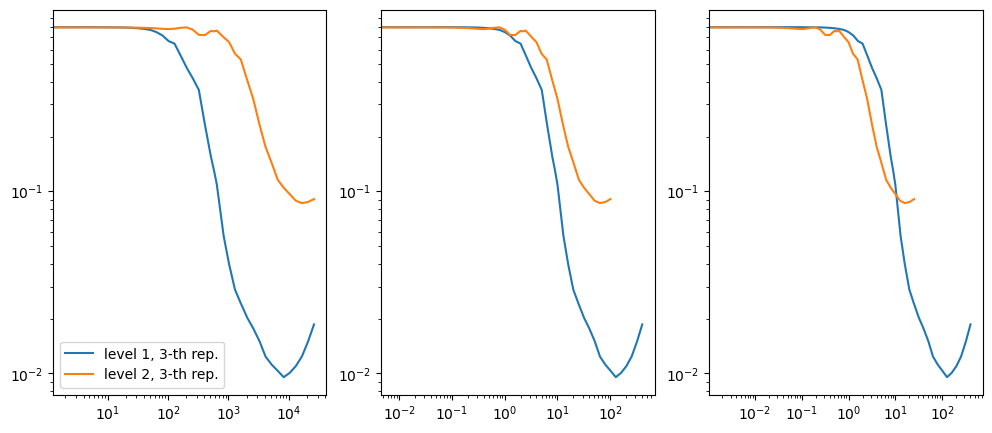

In [51]:
fig, ax = plt.subplots(1, 3, figsize=(12,5))

m = config.num_synonyms

l = 1
k = 3
ax[0].plot([d['t'] for d in dynamics], [(1.-d['synonyms'][k][l].to('cpu'))/((1.-d['noise'][k][l].to('cpu'))) for d in dynamics], f'C{l-1}' , label=f'level {l}, {k}-th rep.')
ax[1].plot([d['t']/(m**(l+2)) for d in dynamics], [(1.-d['synonyms'][k][l].to('cpu'))/((1.-d['noise'][k][l].to('cpu'))) for d in dynamics], f'C{l-1}' , label=f'level {l}, {k}-th rep.')
ax[2].plot([d['t']/(m**(2*(l+1)-1)) for d in dynamics], [(1.-d['synonyms'][k][l].to('cpu'))/((1.-d['noise'][k][l].to('cpu'))) for d in dynamics], f'C{l-1}' , label=f'level {l}, {k}-th rep.')


l = 2
k = 3
ax[0].plot([d['t'] for d in dynamics], [(1.-d['synonyms'][k][l].to('cpu'))/((1.-d['noise'][k][l].to('cpu'))) for d in dynamics], f'C{l-1}' , label=f'level {l}, {k}-th rep.')
ax[1].plot([d['t']/(m**(l+2)) for d in dynamics], [(1.-d['synonyms'][k][l].to('cpu'))/((1.-d['noise'][k][l].to('cpu'))) for d in dynamics], f'C{l-1}' , label=f'level {l}, {k}-th rep.')
ax[2].plot([d['t']/(m**(2*(l+1)-1)) for d in dynamics], [(1.-d['synonyms'][k][l].to('cpu'))/((1.-d['noise'][k][l].to('cpu'))) for d in dynamics], f'C{l-1}' , label=f'level {l}, {k}-th rep.')


ax[0].set_xscale('log')
ax[0].set_yscale('log')

ax[1].set_xscale('log')
ax[1].set_yscale('log')

ax[2].set_xscale('log')
ax[2].set_yscale('log')

ax[0].legend()

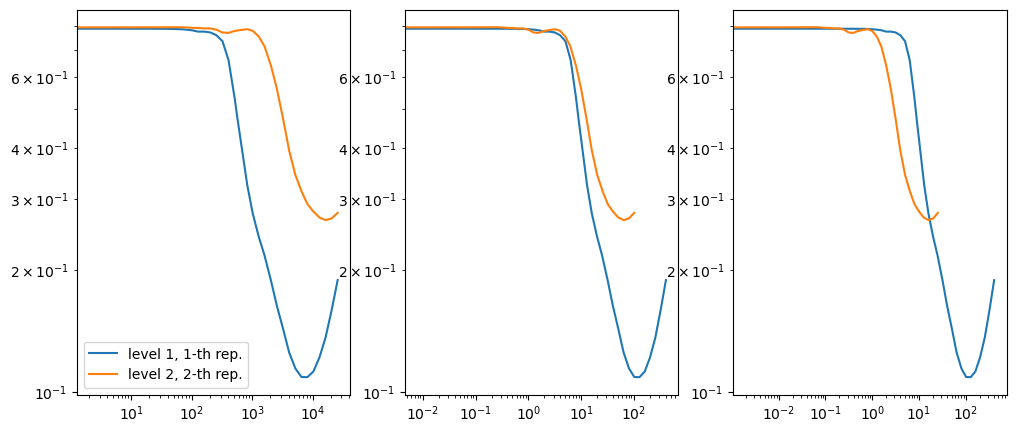

In [50]:
fig, ax = plt.subplots(1, 3, figsize=(12,5))

m = config.num_synonyms

l = 1
k = l
ax[0].plot([d['t'] for d in dynamics], [(1.-d['synonyms'][k][l][-1].to('cpu'))/((1.-d['noise'][k][l][-1].to('cpu'))) for d in dynamics], f'C{l-1}' , label=f'level {l}, {k}-th rep.')
ax[1].plot([d['t']/(m**(l+2)) for d in dynamics], [(1.-d['synonyms'][k][l][-1].to('cpu'))/((1.-d['noise'][k][l][-1].to('cpu'))) for d in dynamics], f'C{l-1}' , label=f'level {l}, {k}-th rep.')
ax[2].plot([d['t']/(m**(2*(l+1)-1)) for d in dynamics], [(1.-d['synonyms'][k][l][-1].to('cpu'))/((1.-d['noise'][k][l][-1].to('cpu'))) for d in dynamics], f'C{l-1}' , label=f'level {l}, {k}-th rep.')


l = 2
k = l
ax[0].plot([d['t'] for d in dynamics], [(1.-d['synonyms'][k][l].to('cpu'))/((1.-d['noise'][k][l].to('cpu'))) for d in dynamics], f'C{l-1}' , label=f'level {l}, {k}-th rep.')
ax[1].plot([d['t']/(m**(l+2)) for d in dynamics], [(1.-d['synonyms'][k][l].to('cpu'))/((1.-d['noise'][k][l].to('cpu'))) for d in dynamics], f'C{l-1}' , label=f'level {l}, {k}-th rep.')
ax[2].plot([d['t']/(m**(2*(l+1)-1)) for d in dynamics], [(1.-d['synonyms'][k][l].to('cpu'))/((1.-d['noise'][k][l].to('cpu'))) for d in dynamics], f'C{l-1}' , label=f'level {l}, {k}-th rep.')


ax[0].set_xscale('log')
ax[0].set_yscale('log')

ax[1].set_xscale('log')
ax[1].set_yscale('log')

ax[2].set_xscale('log')
ax[2].set_yscale('log')

ax[0].legend()